In [6]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [7]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    for row in diff_df.iterrows():
        row = row[1]
#         if row['loop_x']==0:
#             continue
        print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()  

In [13]:

philly_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/pareto.log')

constant 0.0 0 4.020196385260073 0.998176119688133 0.4009819263003653 3.9927044787525316
constant 0.5 0 4.02304061993532 0.9870732131598046 0.4152030996765996 3.9482928526392183
constant 1.0 0 4.029020782073594 0.9501091472045875 0.44510391036797187 3.8004365888183496
constant 2.0 0 4.044734736634914 1.0 0.5236736831745701 4.0
constant 4.0 0 4.074592741342267 0.9482961582635766 0.6729637067113334 3.793184633054307
constant 5.0 0 4.09197996849688 0.9501215006416528 0.7598998424844015 3.800486002566611
constant 7.0 0 4.11645514663519 0.9401921444348028 0.8822757331759521 3.7607685777392112
constant 8.0 0 4.131393724877675 0.8743240135592627 0.9569686243883766 3.497296054237051
constant 16.0 0 4.207328735062035 0.8281096706703007 1.3366436753101738 3.312438682681203
constant 32.0 0 4.3395579555350166 0.6993148759010457 1.9977897776750828 2.7972595036041827
constant 64.0 0 4.441359228728432 0.5045586240394674 2.50679614364216 2.0182344961578695
constant 128.0 0 4.503965347007259 0.34360246

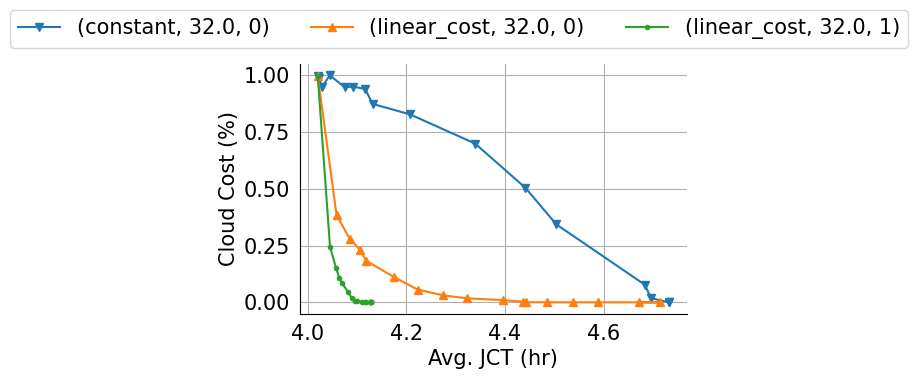

In [48]:
simulator_plotting_fn(philly_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, 'loop': 0},
                      groupby_values=['waiting_policy', 'arrival_rate', 'loop'],
                      normalize_x_axis=True)

In [25]:

sim_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/synthetic/runs.log')

System Utilization: 0.25


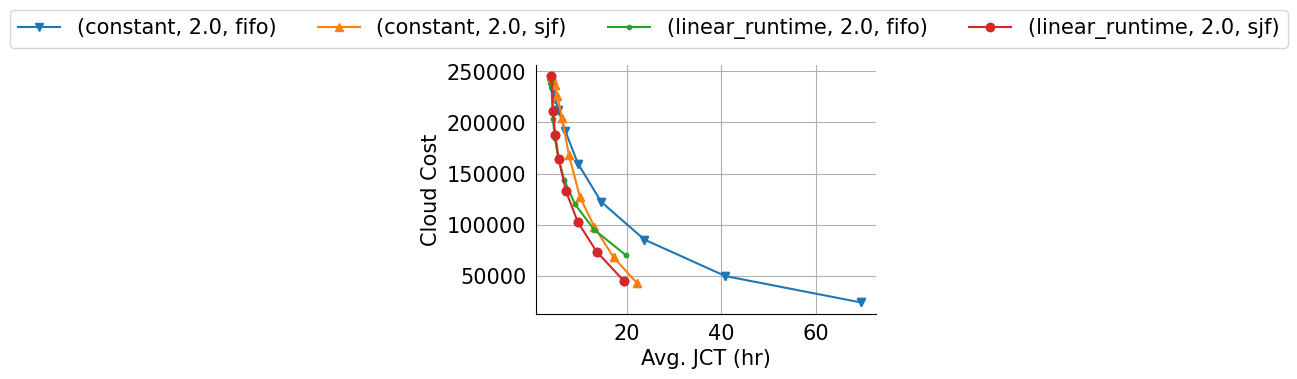

System Utilization: 0.5


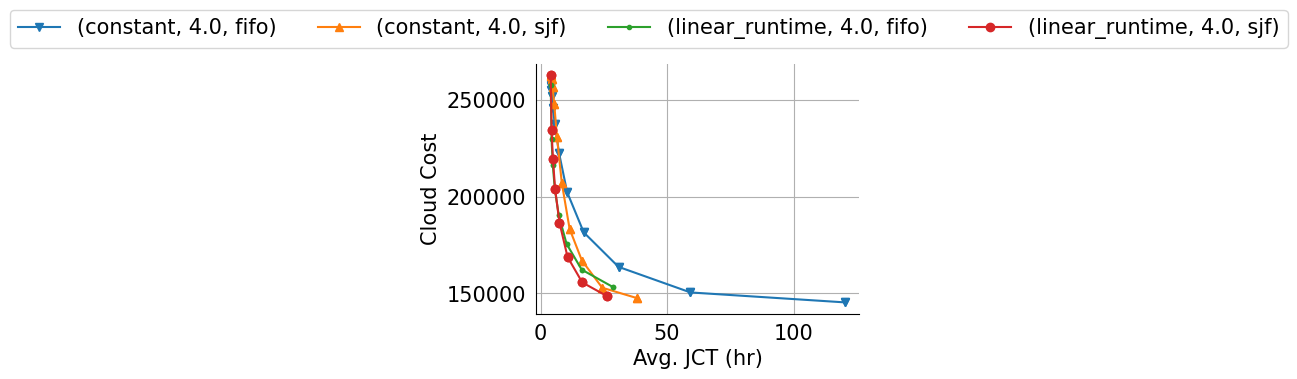

System Utilization: 0.75


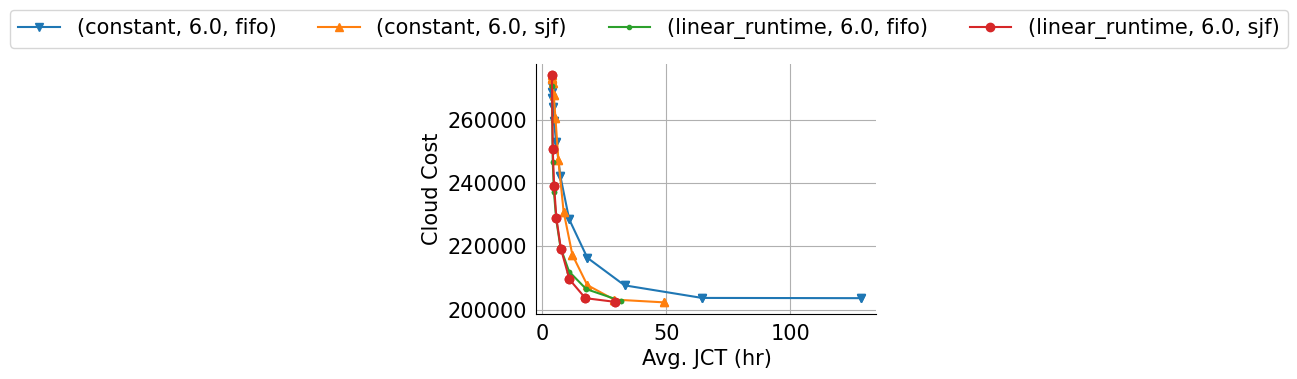

System Utilization: 1.0


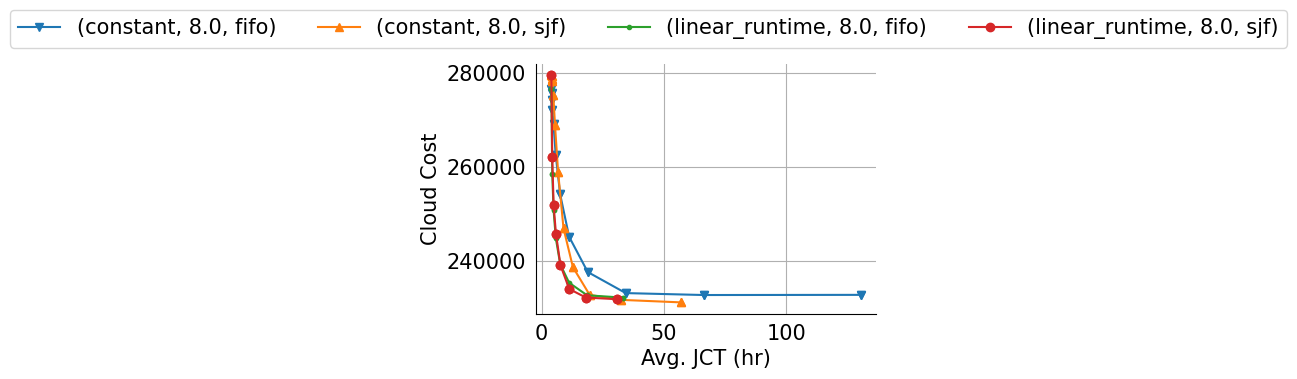

System Utilization: 1.25


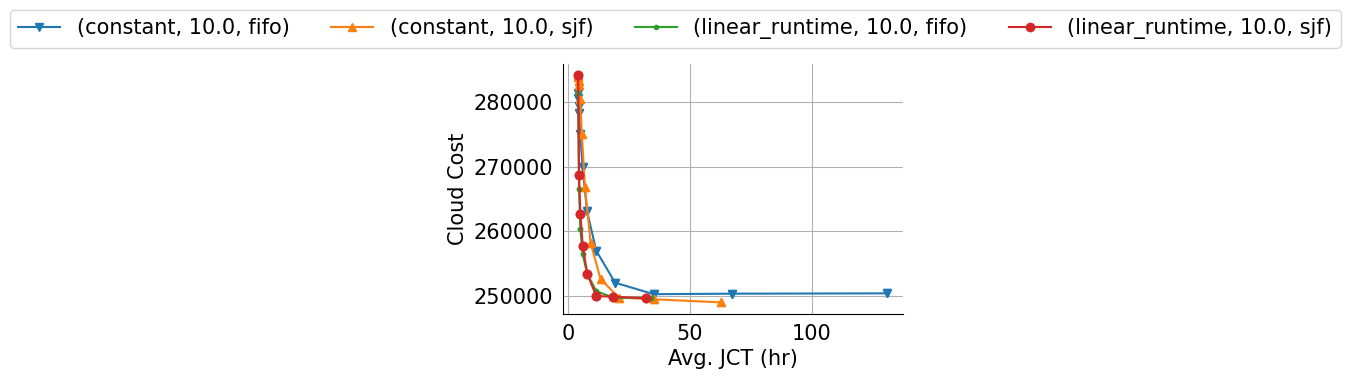

System Utilization: 1.5


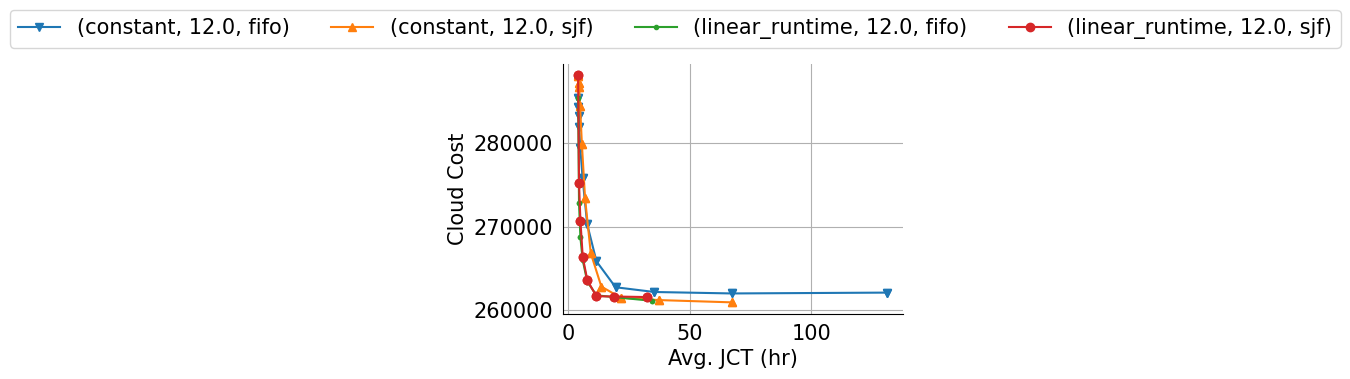

System Utilization: 1.75


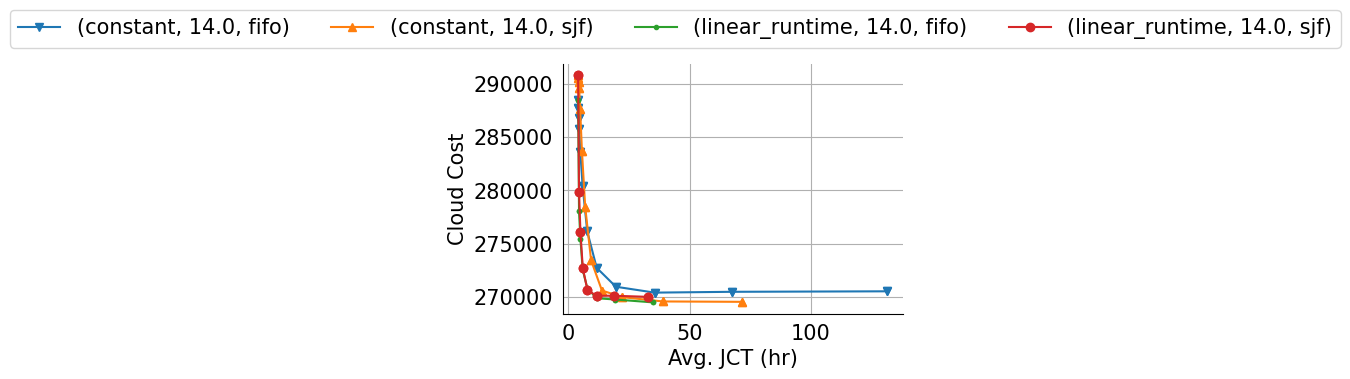

System Utilization: 2.0


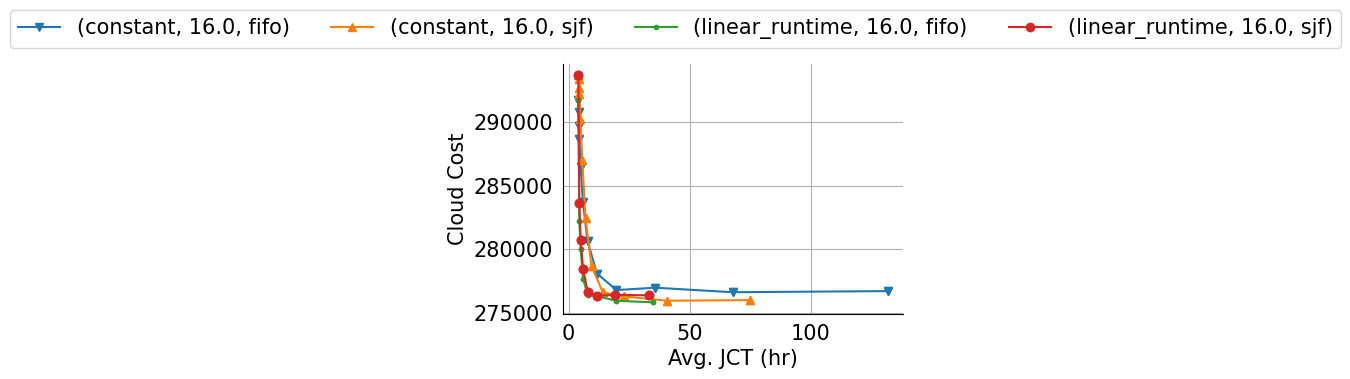

In [26]:
for arr in [2,4,6,8,10,12,14,16]:
    print(f'System Utilization: {arr * 1 / 8}')
    asdf_df = sim_df[sim_df['arrival_rate']==arr]
    simulator_plotting_fn(asdf_df, x_axis='avg_jct',  \
                          y_axis=['total_cloud_cost'], \
                          baseline_filter={'waiting_policy': 'constant','waiting_factor': 0},
                          groupby_values=['waiting_policy', 'arrival_rate', 'sched_alg'],
                          normalize_x_axis=True)

In [27]:

sim_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/synthetic/cluster.log')

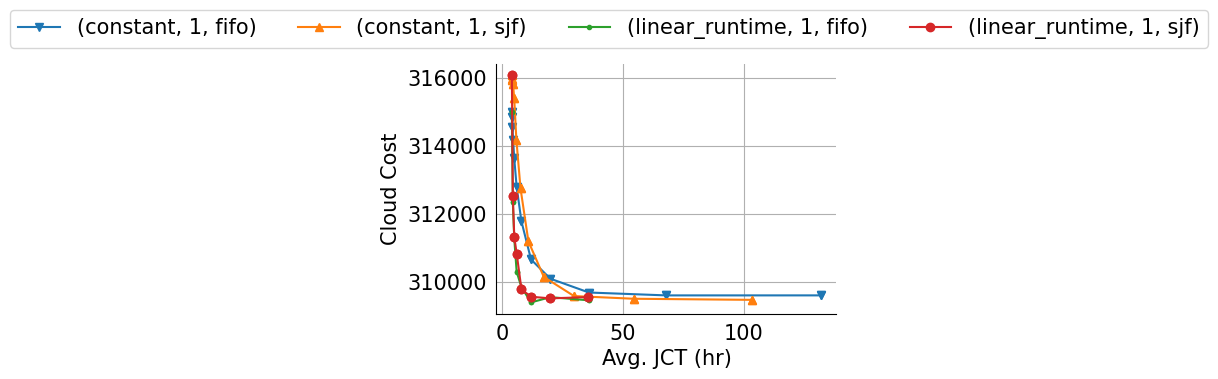

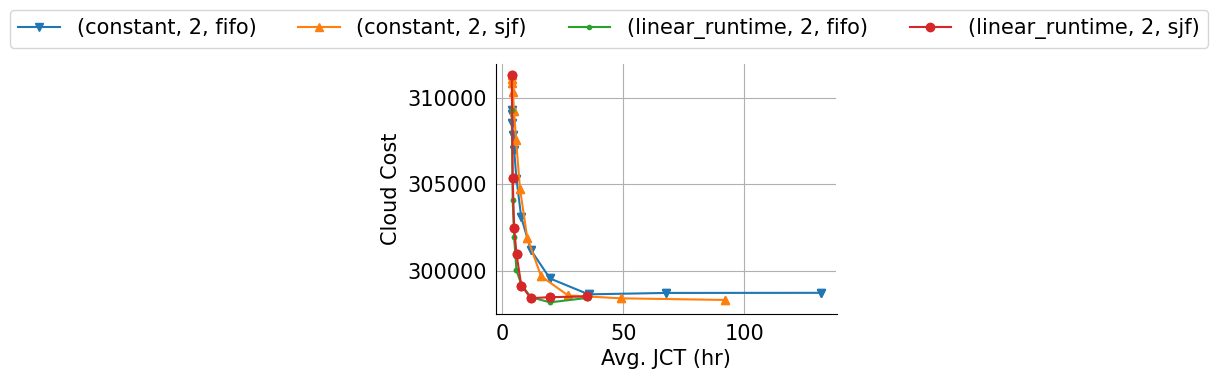

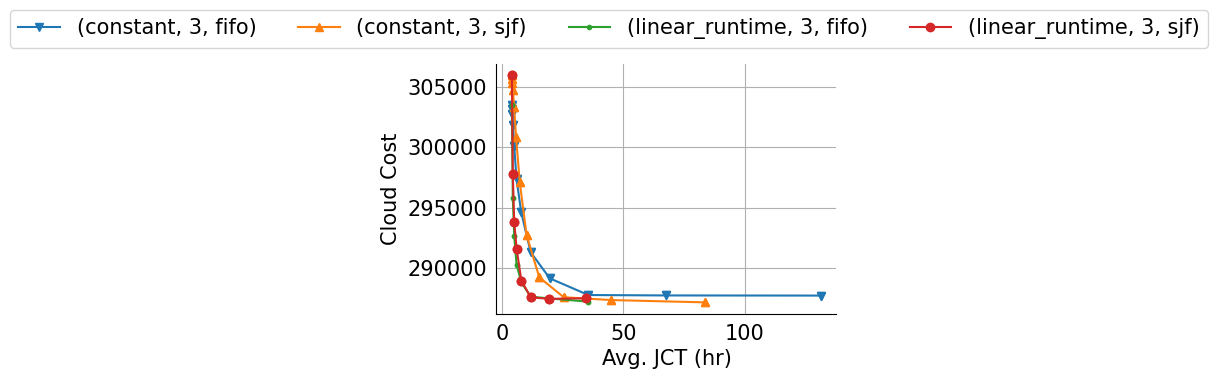

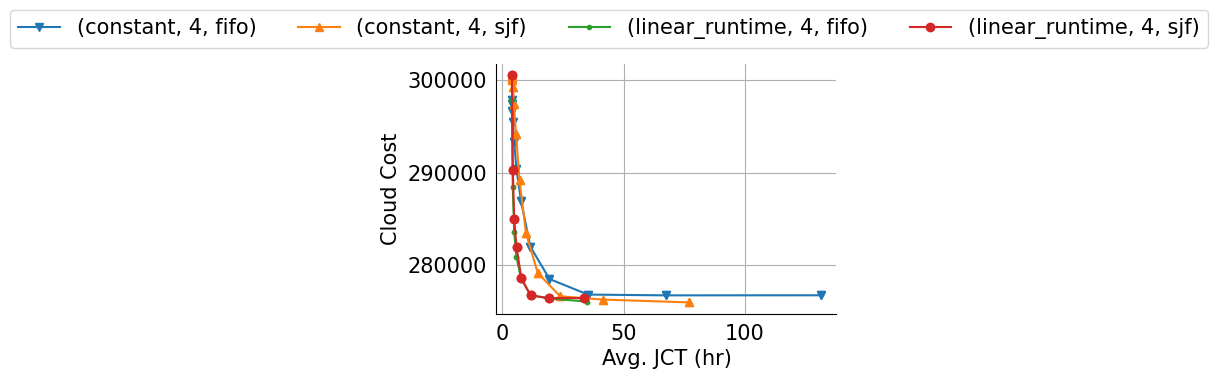

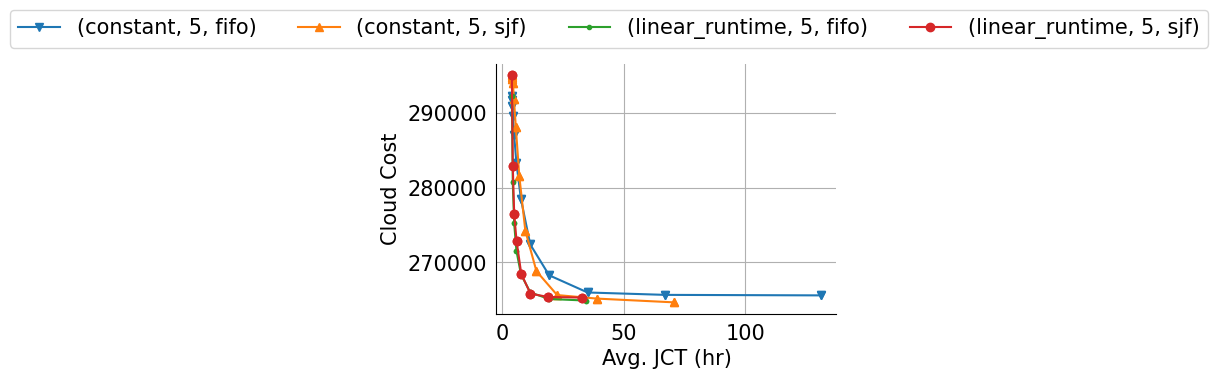

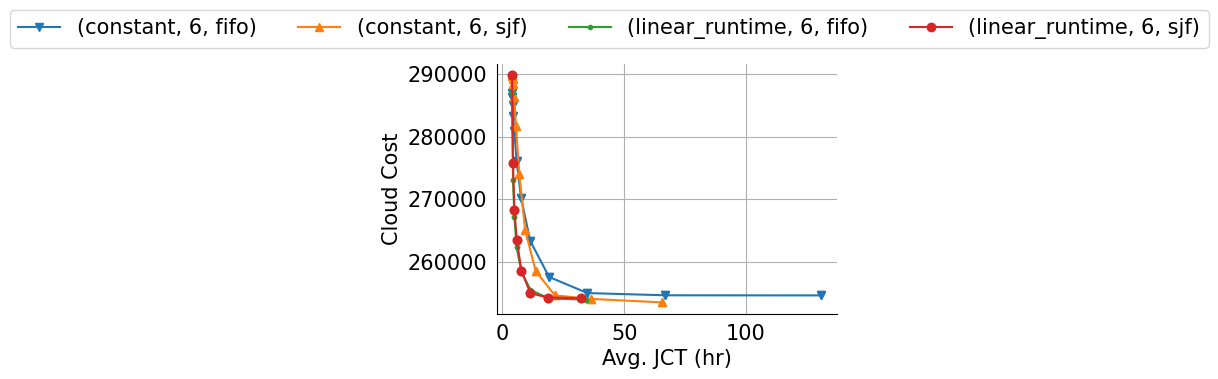

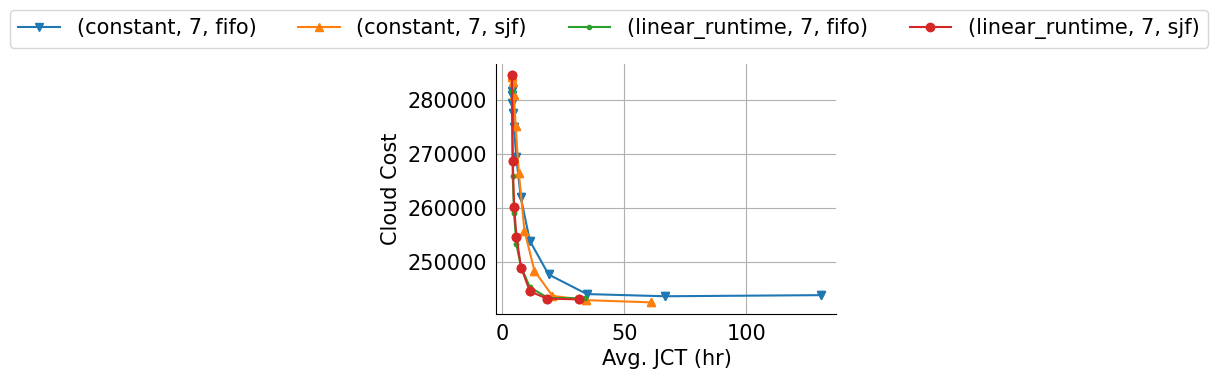

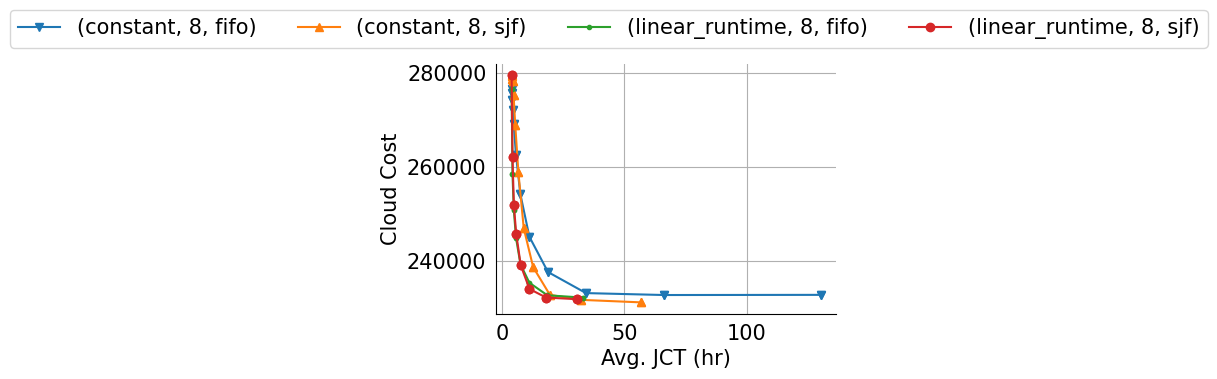

In [28]:
for cluster in [1,2,3,4,5,6,7,8]:
    asdf_df = sim_df[sim_df['cluster_size']==cluster]
    simulator_plotting_fn(asdf_df, x_axis='avg_jct',  \
                          y_axis=['total_cloud_cost'], \
                          baseline_filter={'waiting_policy': 'constant','waiting_factor': 0},
                          groupby_values=['waiting_policy', 'cluster_size', 'sched_alg'],
                          normalize_x_axis=True)

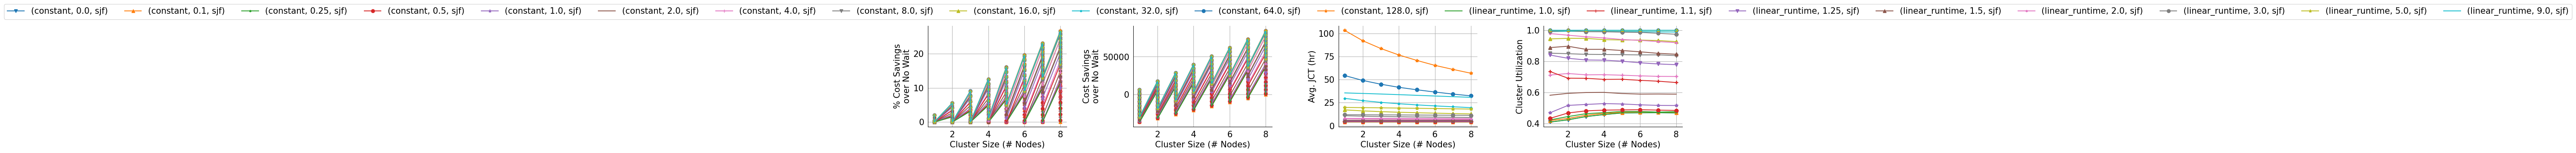

In [43]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    #axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    for row in diff_df.iterrows():
        row = row[1]
        if row['loop_x']==0:
            continue
        print(row['system_utilization_x'], row['waiting_policy_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()  


sim_df = sim_df[sim_df['sched_alg']=='sjf']

simulator_plotting_fn(sim_df, x_axis='cluster_size',  \
                          y_axis=['cost_mult', 'cost_diff', 'avg_jct', 'cluster_utilization'], \
                          baseline_filter={'waiting_policy': 'constant','waiting_factor': 0},
                          groupby_values=['waiting_policy', 'waiting_factor','sched_alg'],
                          normalize_x_axis=False)

In [26]:
print(sim_df['waiting_policy'])

0            constant
1            constant
2            constant
3            constant
4            constant
            ...      
123    linear_runtime
124    linear_runtime
125    linear_runtime
126    linear_runtime
127    linear_runtime
Name: waiting_policy, Length: 128, dtype: object


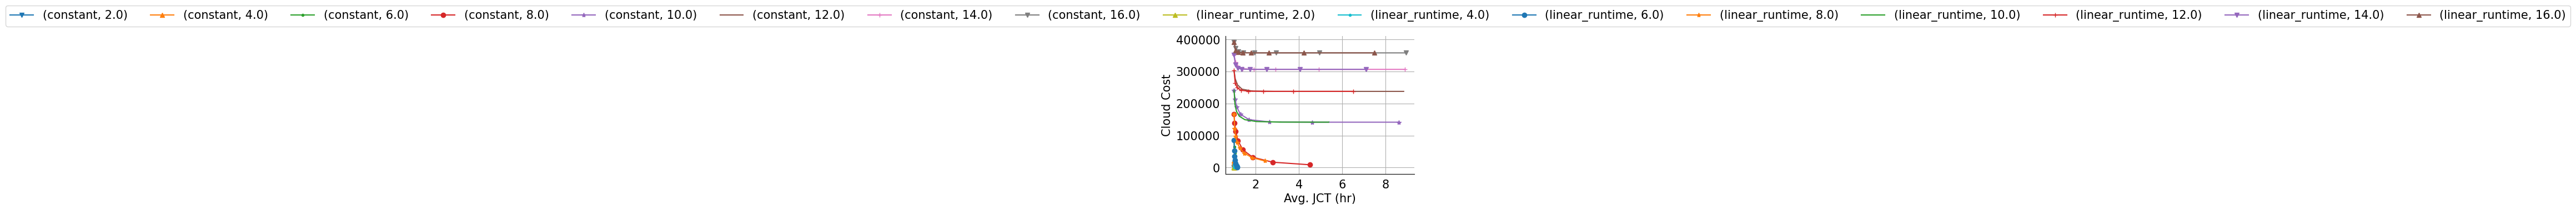

In [62]:
simulator_plotting_fn(sim_df, x_axis='avg_jct',  \
                      y_axis=['total_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0},
                      groupby_values=['waiting_policy', 'arrival_rate'],
                      normalize_x_axis=True)

In [58]:
np.mean(sim_df.iloc[0]['runtime'])

3.9952375575679286

In [66]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):           
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()  

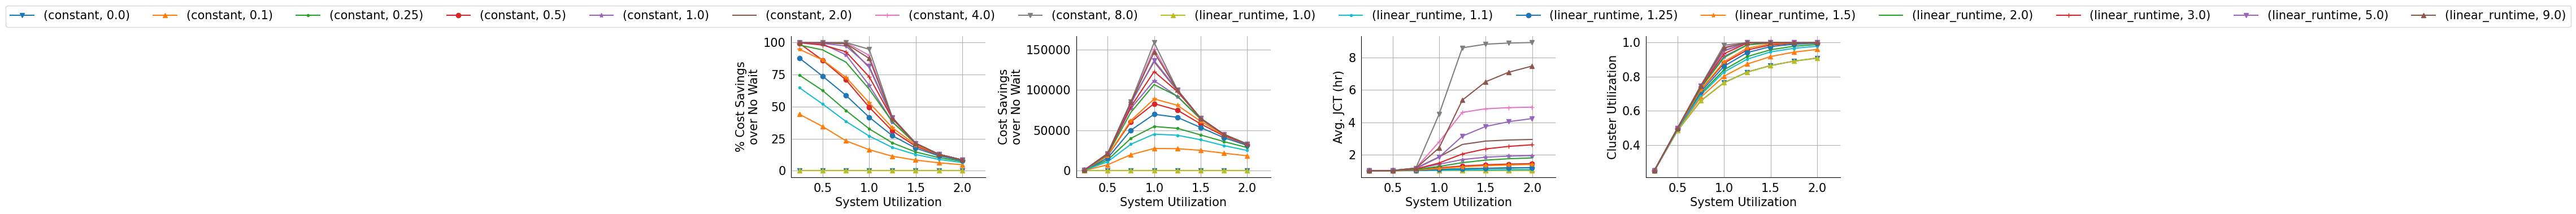

In [67]:
simulator_plotting_fn(sim_df, x_axis='arrival_rate',  \
                      y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0},
                      groupby_values=['waiting_policy', 'waiting_factor',],
                      normalize_x_axis=True)

In [1]:
import pickle
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils
file = open("/home/gcpuser/skyburst/data.pkl",'rb')
job = pickle.load(file)

In [2]:
from skyburst.job import Job
arrival_times = job['arrival']
run_times = job['runtime']
resources = job['num_gpus']
print(np.mean(run_times))
idxs = job['idx']
print(run_times)
lol = zip(arrival_times, run_times, resources)
job_list = []
temp = False
idx=0
for l in sorted(lol):
    if not temp:
        offset = l[0]
        temp=True
    job_list.append(Job(idx=idx, arrival=l[0] - offset, runtime=l[1], resources={'GPUs': l[2]}, cost= l[1]* l[2]))
    idx+=1
print(job_list)

18.054945054945055
[16, 15, 13, 17, 26, 18, 21, 20, 9, 7, 8, 6, 30, 6, 60, 8, 16, 5, 12, 5, 9, 22, 17, 4, 16, 32, 28, 23, 18, 4, 9, 6, 16, 19, 10, 28, 42, 17, 4, 27, 33, 4, 28, 6, 14, 9, 7, 14, 5, 22, 4, 13, 73, 8, 10, 31, 9, 49, 47, 7, 7, 13, 33, 5, 16, 14, 5, 53, 5, 19, 17, 60, 11, 5, 27, 5, 46, 8, 16, 20, 12, 5, 24, 7, 17, 7, 23, 24, 44, 8, 25]
[Job(idx=0, resources={'GPUs': 2, 'CPUs': 0}, arr=0.0, run = 16, deadline=0.0, start=None)
, Job(idx=1, resources={'GPUs': 1, 'CPUs': 0}, arr=2.044724464416504, run = 15, deadline=0.0, start=None)
, Job(idx=2, resources={'GPUs': 4, 'CPUs': 0}, arr=3.995098114013672, run = 13, deadline=0.0, start=None)
, Job(idx=3, resources={'GPUs': 2, 'CPUs': 0}, arr=6.023394584655762, run = 11, deadline=0.0, start=None)
, Job(idx=4, resources={'GPUs': 4, 'CPUs': 0}, arr=8.695385694503784, run = 17, deadline=0.0, start=None)
, Job(idx=5, resources={'GPUs': 1, 'CPUs': 0}, arr=10.699166059494019, run = 5, deadline=0.0, start=None)
, Job(idx=6, resources={'GPUs

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 32307.57it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            constant-2                        1                1262            5.48432        0.526514     18.5815               0.766994               1.31571


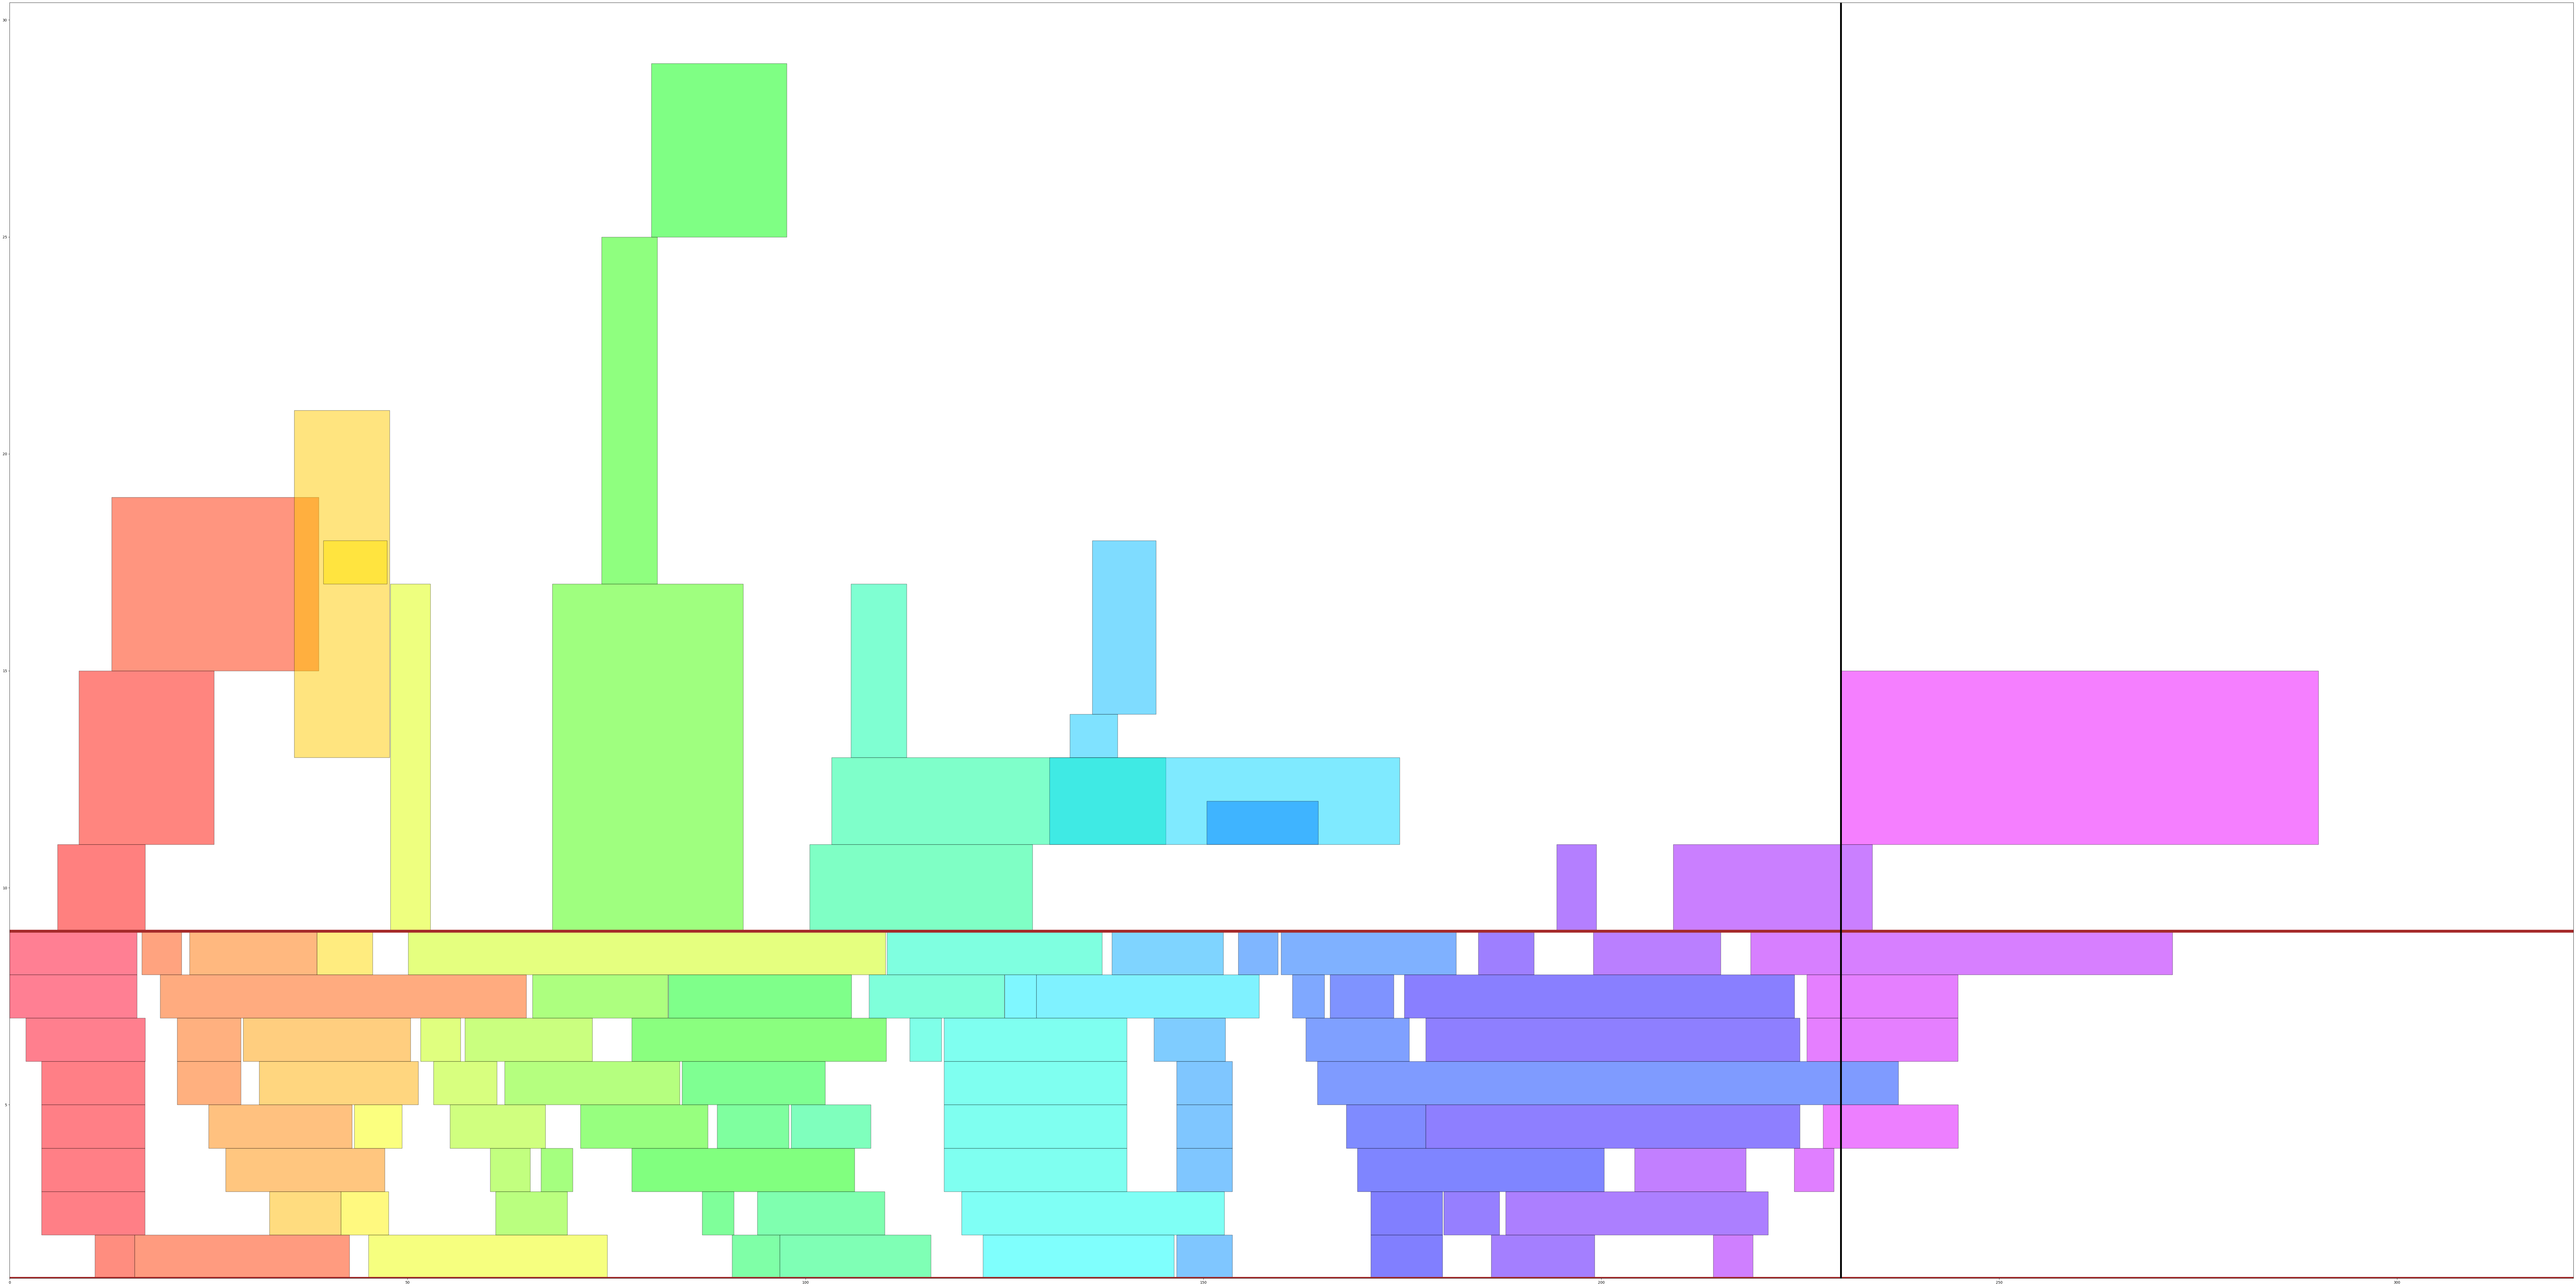

In [3]:
from skyburst.simulator import run_simulator
from skyburst.plot import *

run_config = {
    # Size of the cluster (i.e. # of cluster nodes).
    'cluster_size': 1,
    # Number of GPU(s) per cluster node.
    'gpus_per_node': 8,
    # Number of CPU(s) per cluster node.
    'cpus_per_node': 96,
    # Scheduling algorithm specifying order of the queue.
    'sched_alg': 'fifo',
    # How jobs are binpacked into the cluster.
    'binpack_alg': 'first-fit',
    # Waiting policy (how long jobs should wait in the cloud).
    'waiting_policy': 'constant',
    # Waiting hyperparameter (to be passed to waiting_policy)
    'waiting_factor': 0,
    # Sets clipping time for waiting (max time a job should wait)
    'clip_time': 1e9,
    # Enable backfill (assumes time estimator).
    'backfill': False,
    # Enable loop scheduling (just loop through entire queue, remove HoL).
    'loop': False,
    # Enable prediction. (Jobs predict if they can be assigned to cluster before timing out).
    # 0 is no prediction, 1 is perfect oracle
    'predict_wait': 0,
    # Queue length
    'max_queue_length': -1,
    # Time estimator error
    'time_estimator_error': 0,
    # (Deprecated) Algorithm to immediately send job to cloud (without waiting).
    'filter_alg': None,
    # Prints out simulator state at every timestep.
    'verbose': False,
    # Appends python debugger at every timestemp.
    'debug': False,
    # Position for TQDM progress tracker bar.
    'pbar_idx': 0,
    # Jobs to not consider for final metrics at the beg. and end. of simulator.
    'warmup_jobs': 0,
    # Whether to get snapshots and save to result dict
    'snapshot': False,
    # Metadata on job generation (run prior to simulator).
    'jobgen_spec': {
        # Dataset type ['philly', 'philly_gen', 'gen_gpu']
        'dataset': 'philly',
        # Arrival rate of jobs (used in 'gen_gpu', 'philly_gen')
        'arrival_rate': -1,
        # Total number of jobs generated.
        'total_jobs': -1,
        # Avg. Job runtime (used in 'gen_gpu')
        'job_runtime': -1,
    }
}


run_config['waiting_factor'] = 2
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 35344.17it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            constant-10                       1                1059            4.60214         5.19265     23.2476               0.863859               1.30875


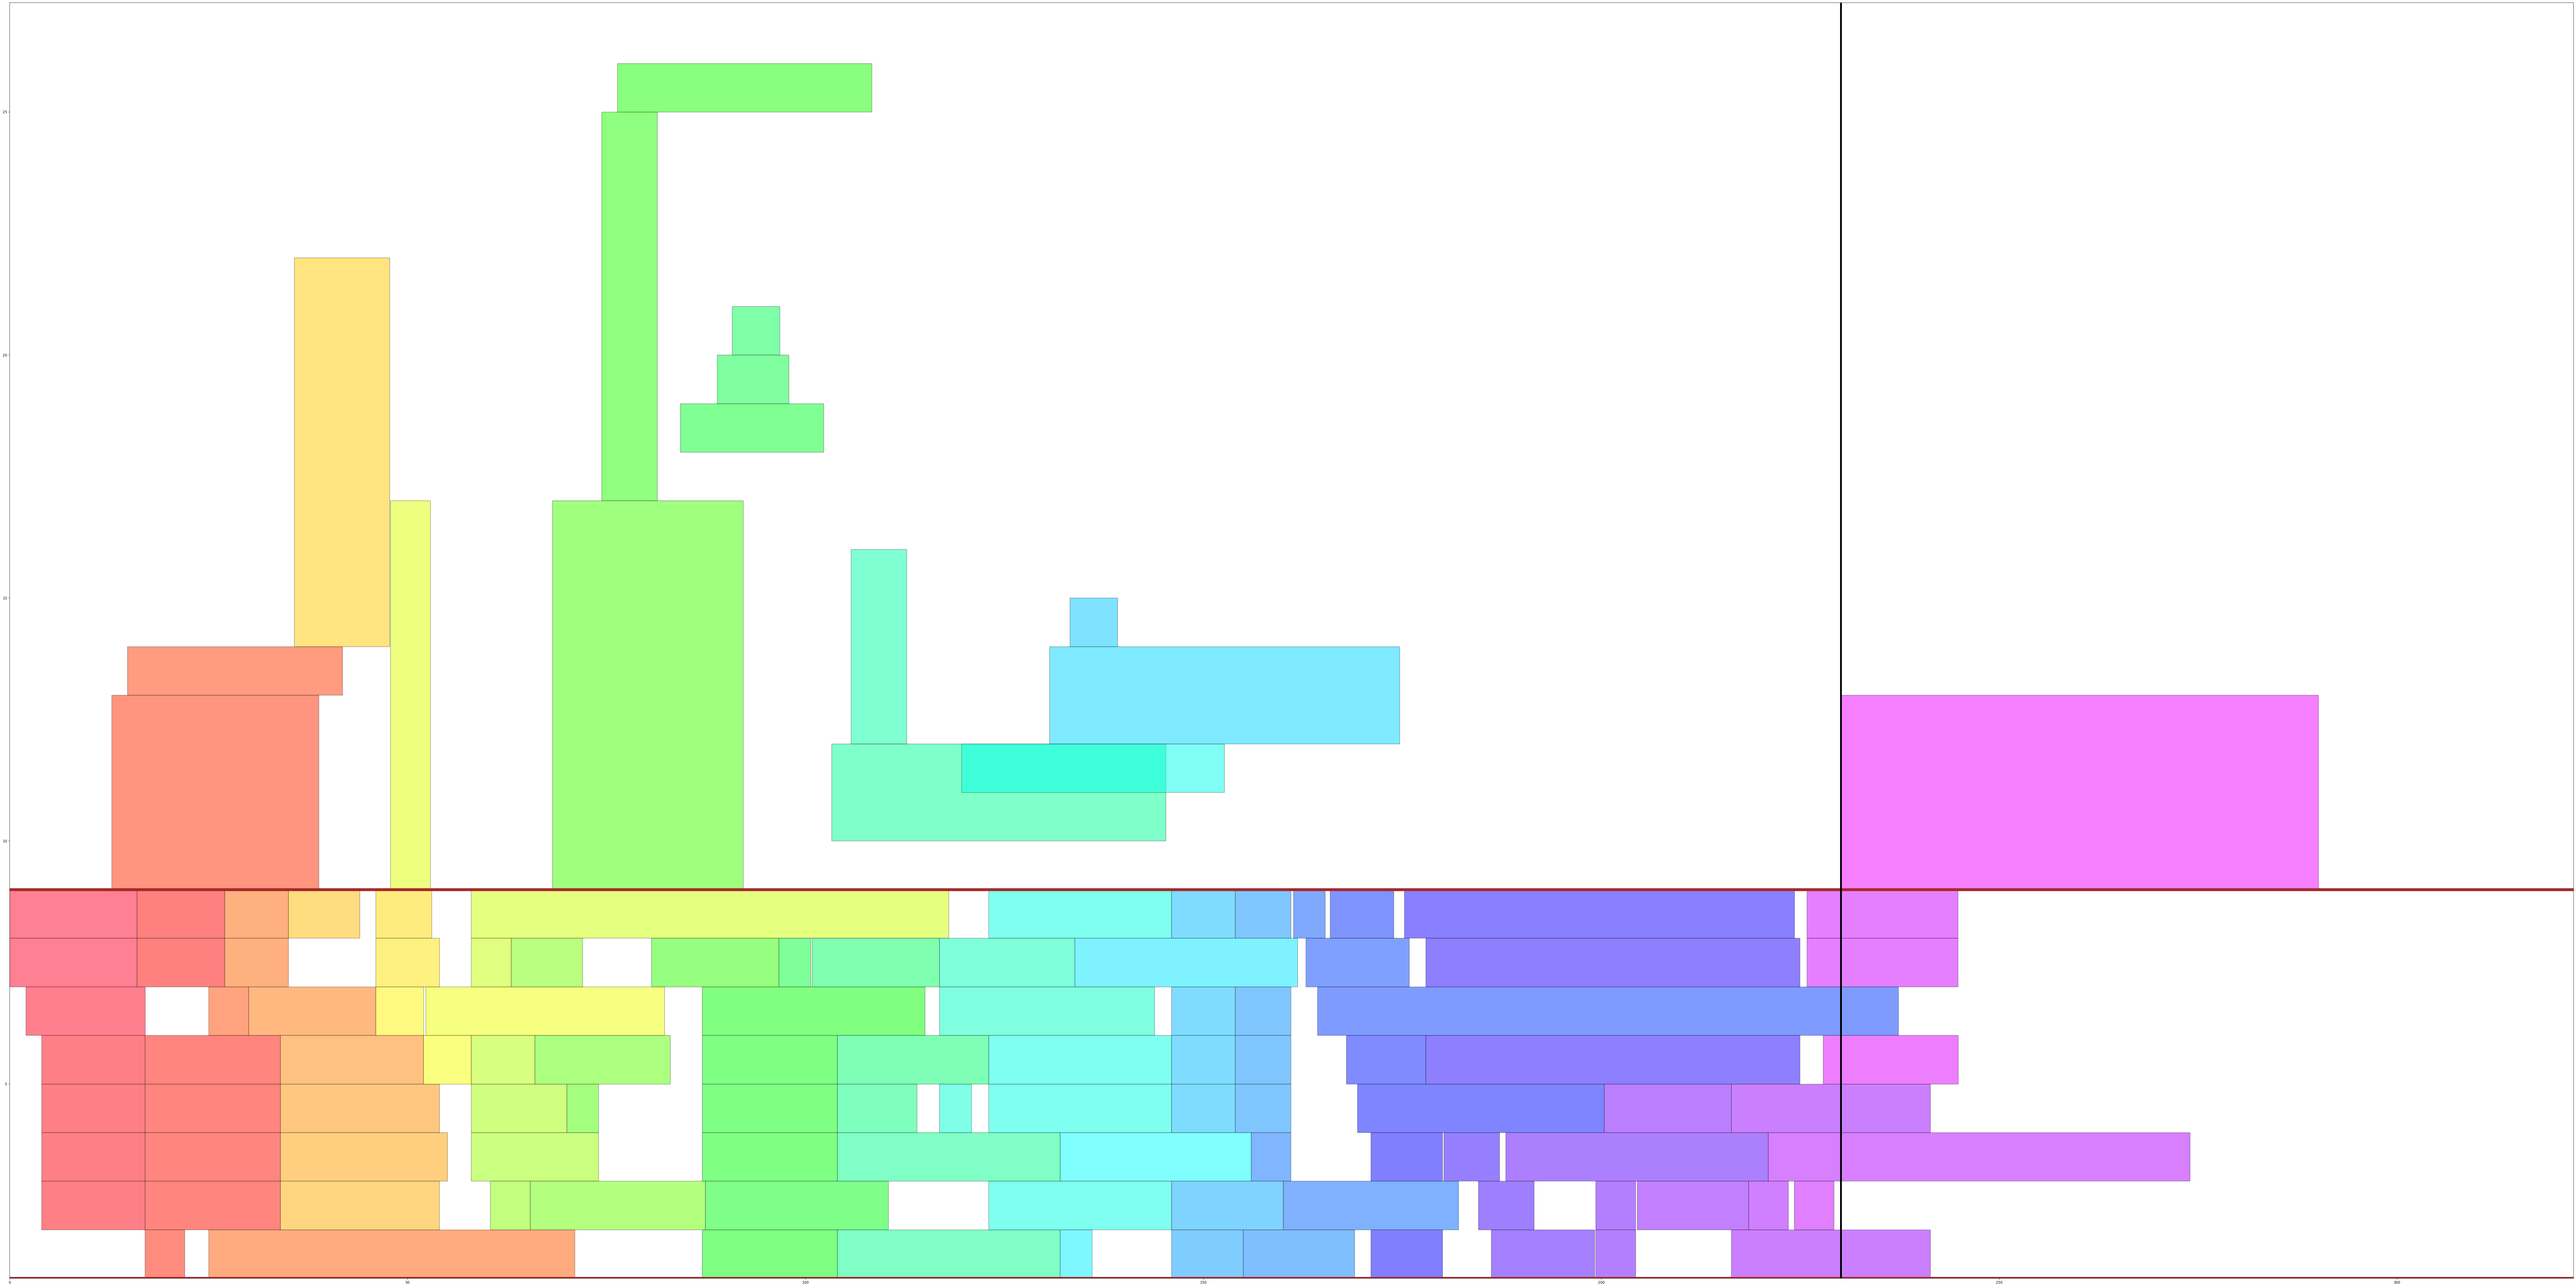

{'idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90]), 'arrival': array([  0.        ,   2.04472446,   3.99509811,   6.02339458,
         8.69538569,  10.69916606,  12.82585788,  14.80480862,
        16.60911655,  18.91407704,  21.0600431 ,  22.61920595,
        25.01416612,  27.13101387,  29.12239146,  31.34432626,
        32.6340456 ,  35.75638676,  37.03053427,  39.43030119,
        41.10754585,  43.15436149,  45.09008741,  47.8527739 ,
        50.07085085,  51.42384219,  53.24070764,  55.32175851,
        57.22092271,  60.39772201,  61.05663681,  62.18464589,
        65.51564145,  66.76047277,  68.17844915,  71.72573853,
      

In [5]:
run_config['waiting_policy'] = 'constant'
run_config['waiting_factor'] = 10
run_config['loop']=0
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)
print(no_wait_results)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 35106.85it/s]


Sched Policy    Waiting Policy                       # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ---------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            linear_runtime-1.5882352941176472                  1                 799            3.47225         2.08685     20.1418               0.873754               1.30778


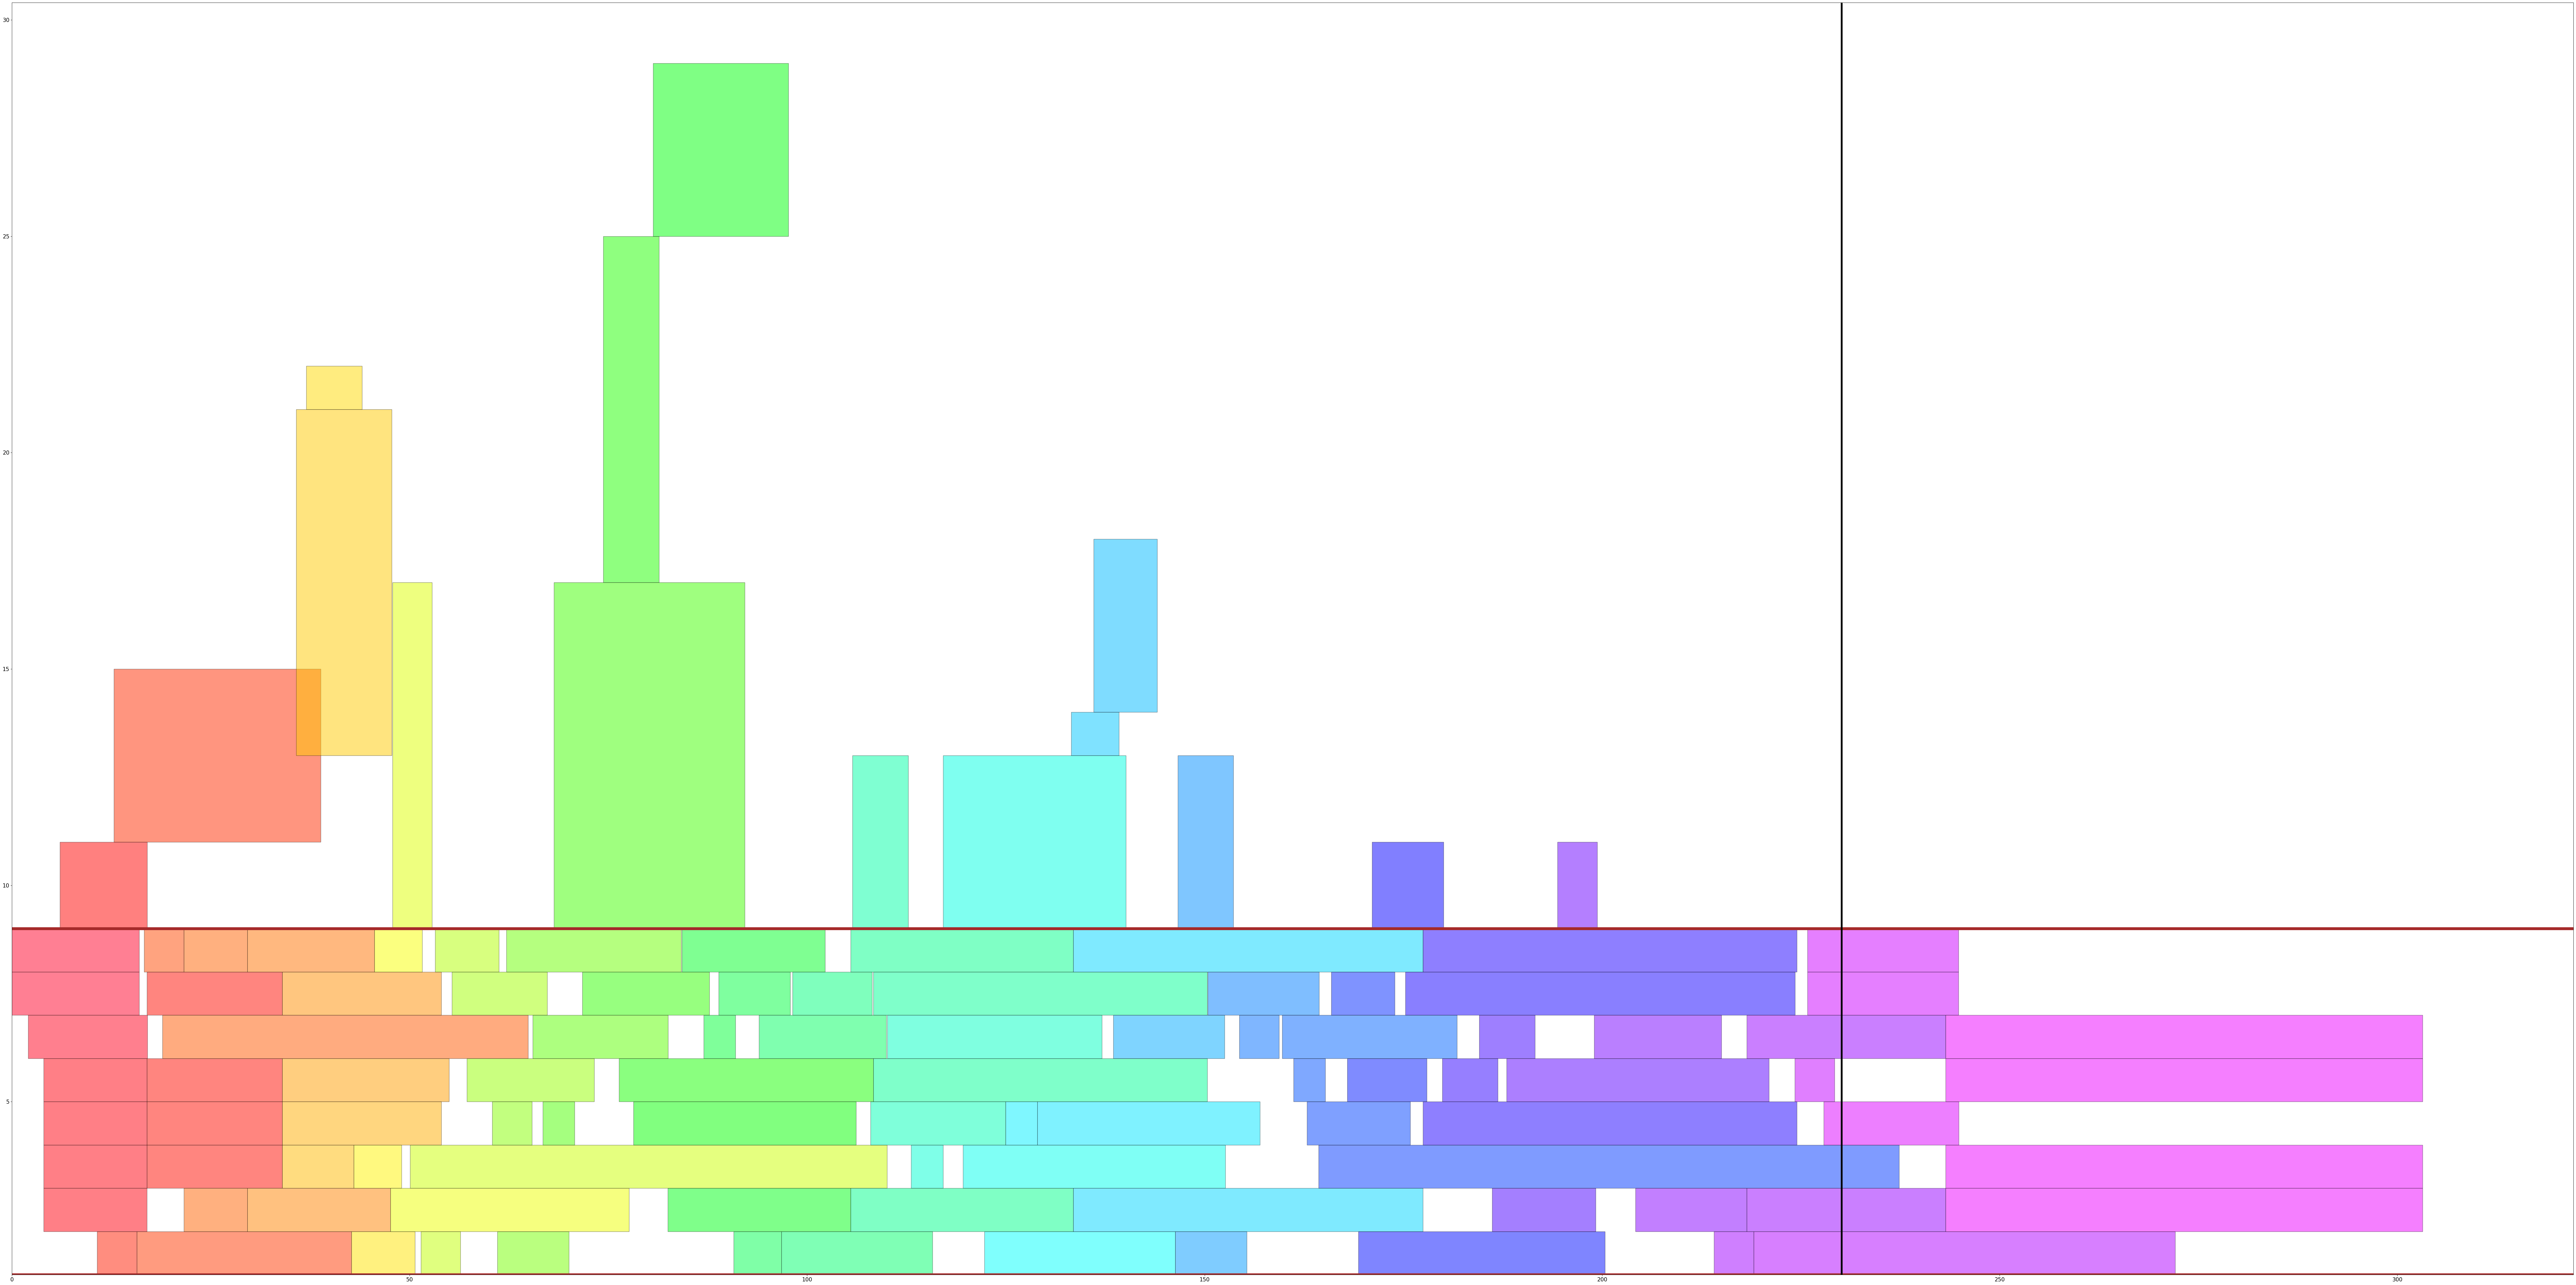

In [53]:
run_config['waiting_policy'] = 'linear_runtime'
run_config['waiting_factor'] = 1 + 10/17
run_config['loop']=1
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)